In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [2]:
df = pd.read_csv("power_data.csv")

le_sensor = LabelEncoder()
le_loc = LabelEncoder()

df["Sensor_ID"] = le_sensor.fit_transform(df["Sensor_ID"])
df["Location"] = le_loc.fit_transform(df["Location"])
df.head()

,Timestamp,Sensor_ID,Voltage (V),Current (A),Power (kW),Frequency (Hz),Power_Factor,Location,Anomaly_Label
0,2024-05-17 12:10:00,3,226.010199,5.645977,1.276048,49.946098,0.930534,0,0
1,2024-05-15 11:44:00,3,222.431527,6.563825,1.460002,50.025096,0.940745,3,0
2,2024-05-18 22:29:00,0,216.612195,6.642216,1.438785,49.955329,0.950015,4,0
3,2024-05-15 16:25:00,3,228.933458,7.091722,1.623532,48.715391,0.960228,0,1
4,2024-05-15 08:51:00,1,230.667943,6.029207,1.390745,48.377455,0.947908,2,1


In [3]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

zones = df["Location"].unique()

feature_cols = ["Voltage (V)", "Current (A)", "Power (kW)", "Frequency (Hz)", "Power_Factor", "Sensor_ID"]

In [4]:
zone_models = {}
zone_scalers = {}

for z in zones:
    zone_train = train_df[train_df["Location"] == z]
    
    X = zone_train[feature_cols]
    y = zone_train["Anomaly_Label"]
    
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = RandomForestClassifier(n_estimators=200, class_weight={0:1,1:4}, random_state=42)
    model.fit(X_scaled, y)
    
    zone_models[z] = model
    zone_scalers[z] = scaler


In [5]:
test_df["Predicted_Anomaly"] = test_df.apply(
    lambda row: zone_models[row["Location"]].predict(
        zone_scalers[row["Location"]].transform(
            pd.DataFrame([row[feature_cols]], columns=feature_cols)
        )
    )[0],
    axis=1
)


In [6]:
y_true = test_df["Anomaly_Label"]
y_pred = test_df["Predicted_Anomaly"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Accuracy: 0.960727969348659

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1750
           1       0.95      0.80      0.87       338

    accuracy                           0.96      2088
   macro avg       0.96      0.89      0.92      2088
weighted avg       0.96      0.96      0.96      2088


Confusion Matrix:
[[1737   13]
 [  69  269]]


In [7]:
reg_features = ["Sensor_ID", "Location", "Frequency (Hz)", "Power_Factor"]
target_cols = ["Voltage (V)", "Current (A)", "Power (kW)"]

X_reg = train_df[reg_features]
y_reg = train_df[target_cols]

reg_scaler = MinMaxScaler()
X_reg_scaled = reg_scaler.fit_transform(X_reg)

reg_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=200, random_state=42))
reg_model.fit(X_reg_scaled, y_reg)

,estimator estimator: estimator objectAn estimator object implementing :term:`fit` and :term:`predict`.,RandomForestR...ndom_state=42)
,"n_jobs n_jobs: int or None, optional (default=None)The number of jobs to run in parallel.:meth:`fit`, :meth:`predict` and :meth:`partial_fit` (if supportedby the passed estimator) will be parallelized for each target.When individual estimators are fast to train or predict,using ``n_jobs > 1`` can result in slower performance dueto the parallelism overhead.``None`` means `1` unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all available processes / threads.See :term:`Glossary ` for more details... versionchanged:: 0.20 `n_jobs` default changed from `1` to `None`.",None
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least

In [8]:
X_test = test_df[reg_features]
X_test_scaled = reg_scaler.transform(X_test)

predicted_values = reg_model.predict(X_test_scaled)

test_df[["Pred_Voltage", "Pred_Current", "Pred_Power"]] = predicted_values


In [9]:
comparison_table = test_df[[
    "Sensor_ID","Location",
    "Voltage (V)","Pred_Voltage",
    "Current (A)","Pred_Current",
    "Power (kW)","Pred_Power",
    "Anomaly_Label","Predicted_Anomaly"
]]

print(comparison_table.head(100))


       Sensor_ID  Location  Voltage (V)  Pred_Voltage  Current (A)  \
5646           3         3   235.852991    232.073283     3.545476   
3107           4         1   223.862789    225.772824     6.657980   
7431           4         1   190.879314    232.805281     4.475402   
10019          4         2   233.450414    228.504814     7.202326   
9066           3         3   227.229740    231.301124     4.545299   
...          ...       ...          ...           ...          ...   
457            4         4   226.013500    234.971702     4.150133   
311            2         4   236.546054    220.856898     5.338746   
765            0         2   235.961674    235.117792     4.376646   
4194           4         2   229.269301    229.906218     4.862665   
7911           2         0   234.937687    234.524955     4.517385   

       Pred_Current  Power (kW)  Pred_Power  Anomaly_Label  Predicted_Anomaly  
5646       4.645165    0.836211    1.106074              0                  0  

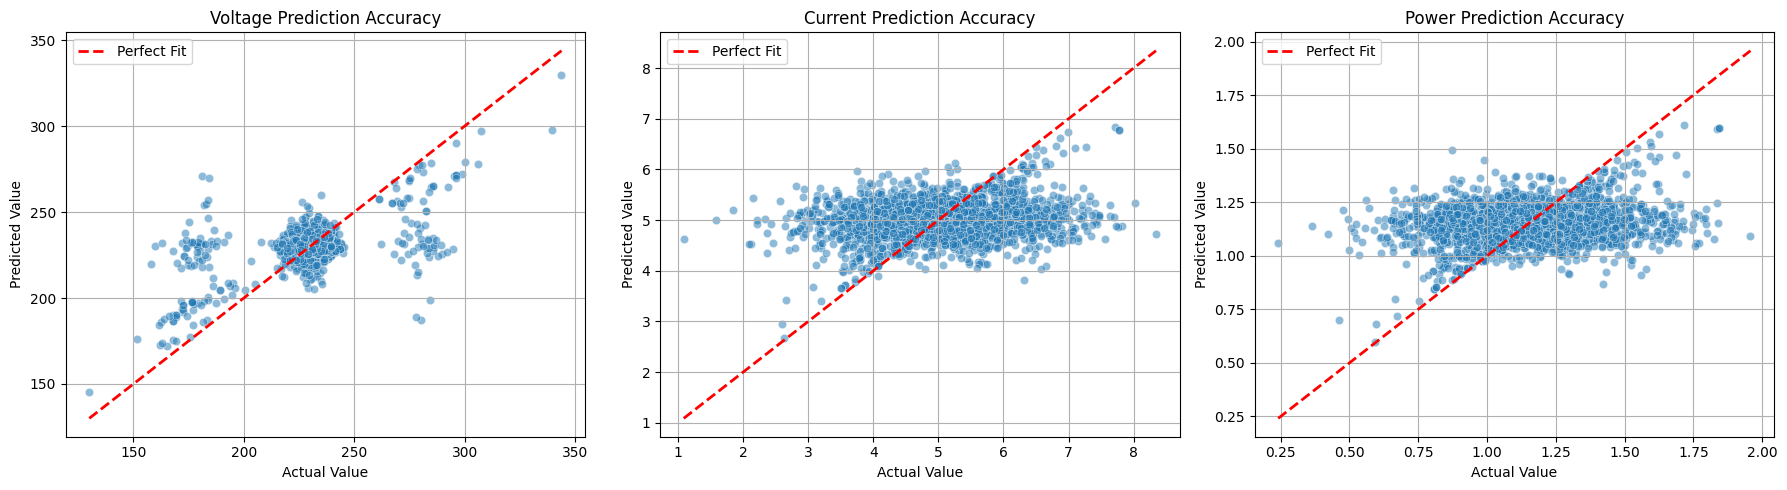

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = [
    ("Voltage (V)", "Pred_Voltage"),
    ("Current (A)", "Pred_Current"),
    ("Power (kW)",  "Pred_Power")
]

for i, (col_actual, col_pred) in enumerate(metrics):
    ax = axes[i]

    sns.scatterplot(
        x=comparison_table[col_actual],
        y=comparison_table[col_pred],
        ax=ax,
        alpha=0.5
    )

    min_val = min(
        comparison_table[col_actual].min(),
        comparison_table[col_pred].min()
    )
    max_val = max(
        comparison_table[col_actual].max(),
        comparison_table[col_pred].max()
    )

    ax.plot([min_val, max_val], [min_val, max_val],
            'r--', linewidth=2, label='Perfect Fit')

    ax.set_title(f"{col_actual.split()[0]} Prediction Accuracy")
    ax.set_xlabel("Actual Value")
    ax.set_ylabel("Predicted Value")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


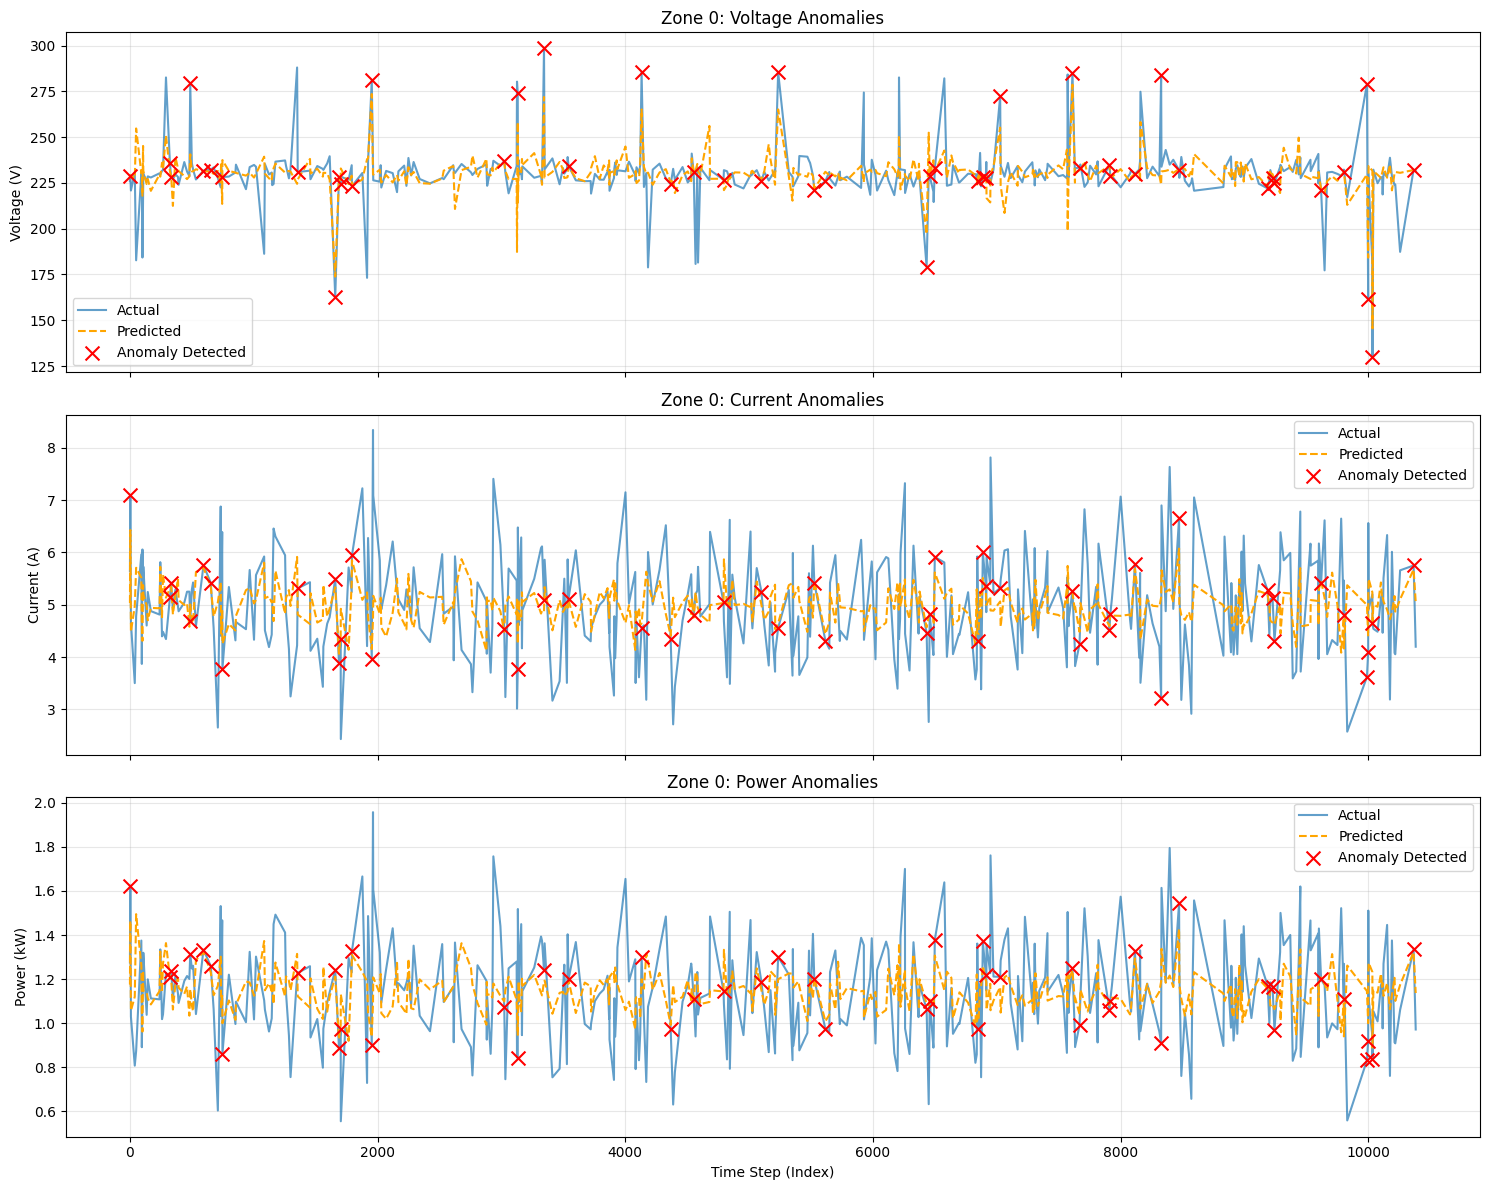

In [15]:
import seaborn as sns

comparison_table = test_df[[
    "Sensor_ID", "Location",
    "Voltage (V)", "Pred_Voltage",
    "Current (A)", "Pred_Current",
    "Power (kW)", "Pred_Power",
    "Anomaly_Label", "Predicted_Anomaly"
]]

# ANOMALY DASHBOARD
zone = zones[0]
zone_df = test_df[test_df["Location"] == zone].sort_index()

fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

def plot_zone_metric(ax, actual, predicted, anomalies, title, ylabel):
    ax.plot(actual.index, actual, label="Actual", color='tab:blue', alpha=0.7)
    ax.plot(predicted.index, predicted, label="Predicted", color='orange', linestyle='--')
    
    ax.scatter(anomalies.index, actual.loc[anomalies.index], 
               color='red', label='Anomaly Detected', marker='x', s=100, zorder=5)
    
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True, alpha=0.3)

anoms = zone_df[zone_df["Predicted_Anomaly"] == 1]

plot_zone_metric(axes[0], zone_df["Voltage (V)"], zone_df["Pred_Voltage"], anoms, 
                 f"Zone {zone}: Voltage Anomalies", "Voltage (V)")

plot_zone_metric(axes[1], zone_df["Current (A)"], zone_df["Pred_Current"], anoms, 
                 f"Zone {zone}: Current Anomalies", "Current (A)")

plot_zone_metric(axes[2], zone_df["Power (kW)"], zone_df["Pred_Power"], anoms, 
                 f"Zone {zone}: Power Anomalies", "Power (kW)")

plt.xlabel("Time Step (Index)")
plt.tight_layout()
plt.show()

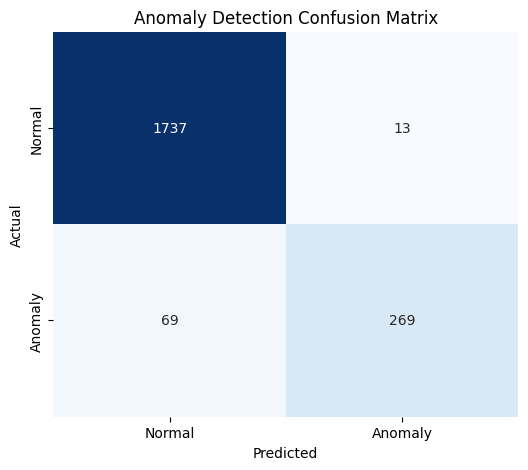

In [16]:
# CONFUSION MATRIX HEATMAP

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Anomaly Detection Confusion Matrix')
plt.show()

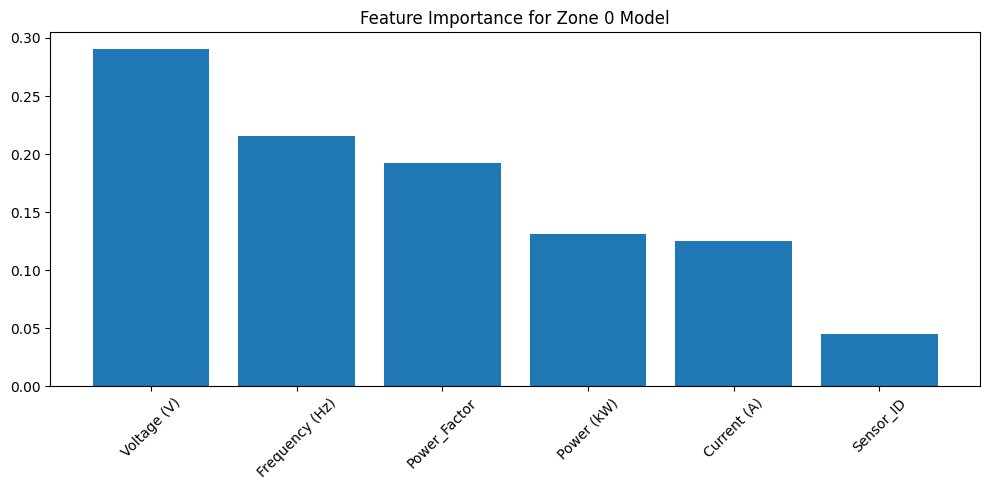

In [17]:
example_model = zone_models[zones[0]]
importances = example_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title(f"Feature Importance for Zone {zones[0]} Model")
plt.bar(range(len(feature_cols)), importances[indices], align="center")
plt.xticks(range(len(feature_cols)), [feature_cols[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

In [18]:
print("\nLive Alerts:")
for _, row in comparison_table[comparison_table["Predicted_Anomaly"] == 1].head(10).iterrows():
    print(f"ALERT: Sensor {row['Sensor_ID']} in Zone {row['Location']} is ANOMALOUS")


Live Alerts:
ALERT: Sensor 4.0 in Zone 4.0 is ANOMALOUS
ALERT: Sensor 4.0 in Zone 2.0 is ANOMALOUS
ALERT: Sensor 3.0 in Zone 4.0 is ANOMALOUS
ALERT: Sensor 1.0 in Zone 0.0 is ANOMALOUS
ALERT: Sensor 2.0 in Zone 4.0 is ANOMALOUS
ALERT: Sensor 2.0 in Zone 4.0 is ANOMALOUS
ALERT: Sensor 4.0 in Zone 0.0 is ANOMALOUS
ALERT: Sensor 0.0 in Zone 2.0 is ANOMALOUS
ALERT: Sensor 4.0 in Zone 2.0 is ANOMALOUS
ALERT: Sensor 2.0 in Zone 0.0 is ANOMALOUS


In [ ]:
#Node Visualization

In [20]:
sensor_network = test_df[[
    "Sensor_ID",
    "Location",
    "Voltage (V)",
    "Current (A)",
    "Power (kW)",
    "Predicted_Anomaly"
]]

In [21]:
sensor_network.to_csv("sensor_network.csv", index=False)

In [22]:
alerts = []

for _, row in test_df[test_df["Predicted_Anomaly"] == 1 ].iterrows():
    alerts.append({
        "sensor": int(row["Sensor_ID"]),
        "zone": int(row["Location"]),
        "voltage": float(row["Voltage (V)"]),
        "current": float(row["Current (A)"]),
        "power": float(row["Power (kW)"]),
        "timestamp": str(row["Timestamp"]),
        "alert": "ANOMALY DETECTED"
    })

import json
alert_json = json.dumps(alerts, indent=2)

print(alert_json[:1000])


[
  {
    "sensor": 4,
    "zone": 4,
    "voltage": 223.27484325054013,
    "current": 4.985898498411425,
    "power": 1.1132257056959145,
    "timestamp": "2024-05-16 21:36:00",
    "alert": "ANOMALY DETECTED"
  },
  {
    "sensor": 4,
    "zone": 2,
    "voltage": 183.9153156898749,
    "current": 6.521427965037024,
    "power": 1.5637622876526802,
    "timestamp": "2024-05-18 19:47:00",
    "alert": "ANOMALY DETECTED"
  },
  {
    "sensor": 3,
    "zone": 4,
    "voltage": 226.9348069001618,
    "current": 5.208092183436559,
    "power": 1.1818973939664177,
    "timestamp": "2024-05-13 09:57:00",
    "alert": "ANOMALY DETECTED"
  },
  {
    "sensor": 1,
    "zone": 0,
    "voltage": 232.98131556736303,
    "current": 5.914046347850621,
    "power": 1.3778622984485964,
    "timestamp": "2024-05-16 08:17:00",
    "alert": "ANOMALY DETECTED"
  },
  {
    "sensor": 2,
    "zone": 4,
    "voltage": 162.39712475641625,
    "current": 5.607032959110933,
    "power": 1.2949398124739764,
  

In [23]:
with open("live_alerts.json", "w") as f:
    f.write(alert_json)

In [24]:
# import json
# import numpy as np

# if "Timestamp" in test_df.columns:
#     test_df["Timestamp"] = test_df["Timestamp"].astype(str)

# input_features = ["Sensor_ID", "Location", "Voltage (V)", "Current (A)", 
#                   "Power (kW)", "Frequency (Hz)", "Power_Factor"]

# if "Timestamp" in test_df.columns:
#     input_features.insert(0, "Timestamp")

# input_data_list = test_df[input_features].to_dict(orient="records")

# with open("input_data.json", "w") as f:
#     json.dump(input_data_list, f, indent=4)
#     print(f"SUCCESS: 'input_data.json' created with {len(input_data_list)} records.")

# anomaly_records = []

# TOLERANCE_V = 0.05  # 5%
# TOLERANCE_I = 0.20  # 20%
# TOLERANCE_P = 0.20  # 20%

# anomalies_df = comparison_table[comparison_table["Predicted_Anomaly"] == 1]

# for index, row in anomalies_df.iterrows():
    
#     pred_v = row["Pred_Voltage"] if row["Pred_Voltage"] != 0 else 1e-6
#     pred_i = row["Pred_Current"] if row["Pred_Current"] != 0 else 1e-6
#     pred_p = row["Pred_Power"]   if row["Pred_Power"]   != 0 else 1e-6

#     dev_v = abs((row["Voltage (V)"] - pred_v) / pred_v)
#     dev_i = abs((row["Current (A)"] - pred_i) / pred_i)
#     dev_p = abs((row["Power (kW)"] - pred_p) / pred_p)
    
#     score_v = dev_v / TOLERANCE_V
#     score_i = dev_i / TOLERANCE_I
#     score_p = dev_p / TOLERANCE_P
    
#     severity_score = max(score_v, score_i, score_p)
    
#     timestamp_val = "N/A"
#     if "Timestamp" in test_df.columns:
#         timestamp_val = str(test_df.loc[index, "Timestamp"])

#     record = {
#         "sensor": int(row["Sensor_ID"]),
#         "zone": int(row["Location"]),
#         "voltage": float(row["Voltage (V)"]),
#         "current": float(row["Current (A)"]),
#         "power": float(row["Power (kW)"]),
#         "timestamp": timestamp_val,
#         "alert": "ANOMALY DETECTED",
#         "severity_score": round(severity_score, 2)
#     }
    
#     anomaly_records.append(record)

# with open("anomaly_output.json", "w") as f:
#     json.dump(anomaly_records, f, indent=4)
#     print(f"SUCCESS: 'anomaly_output.json' created with {len(anomaly_records)} alerts.")

In [25]:
import joblib
import os

# Create directory if it doesn't exist
os.makedirs('models/physical', exist_ok=True)

print(">>> SAVING TRAINED MODELS FOR FLASK...")

# Save the dictionary of classifiers
joblib.dump(zone_models, 'models/physical/zone_models.joblib')

# Save the dictionary of scalers
joblib.dump(zone_scalers, 'models/physical/zone_scalers.joblib')

print(">>> SUCCESS: Models saved to 'models/physical/'")
print(">>> YOU MUST NOW MOVE THESE FILES TO YOUR FLASK PROJECT FOLDER.")

>>> SAVING TRAINED MODELS FOR FLASK...
>>> SUCCESS: Models saved to 'models/physical/'
>>> YOU MUST NOW MOVE THESE FILES TO YOUR FLASK PROJECT FOLDER.
